This notebook deals with the figure detection and segmentation using persistent homology.
    
This is based on the following articles:

https://doi.org/10.14495/jsiaml.15.33

https://doi.org/10.1038/s41598-023-37760-3

https://doi.org/10.14495/jsiaml.16.25

The image is taken from BBBC005v1

(Broad Bioimage Benchmark Collection; Ljosa, V., Sokolnicki, K. L. & Carpenter, A. E. Annotated high-throughput microscopy image sets for validation. Nat. Methods 9, 637 (2012)).

The latter part is the slight modification of the detection method to the segmentation method.

Instead of plotting the circumcenter of the death positions, we draw the birth simplices.

In [1]:
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
import copy
from skimage.color import label2rgb

In [2]:
img = cv2.imread('SIMCEPImages_A17_C70_F1_s09_w1.tif', cv2.IMREAD_GRAYSCALE)

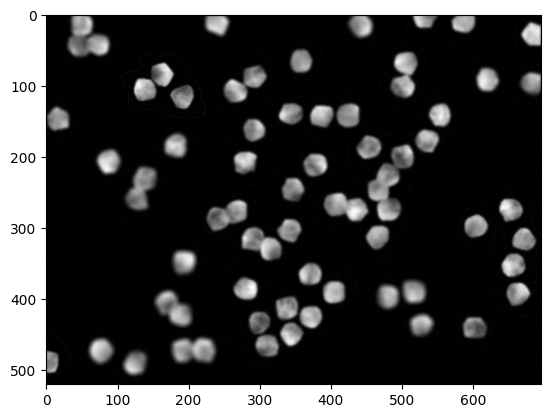

In [3]:
plt.imshow(img,cmap='gray')
plt.show()

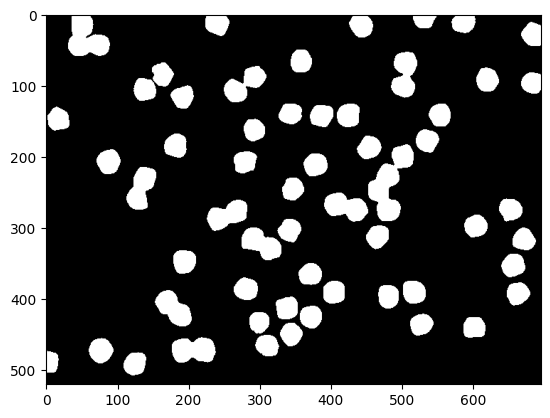

In [4]:
ret, img_binary = cv2.threshold(img, 60, 255,cv2.THRESH_BINARY)
plt.imshow(img_binary,cmap='gray')
plt.show()

In [5]:
%%time
BDsizethreshold=30#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=8#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=1#######threshold value for the persistence
boundary_death_positions=[]
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    for w in range (0,len(pairs)):
        if pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            boundary_death_positions.append([x,y,pairs[w].death_time()])
positionnumber=len(boundary_death_positions)
print(positionnumber, "figures detected")
center_position=np.array(boundary_death_positions)
CenterList=copy.deepcopy(center_position)

70 figures detected
CPU times: total: 375 ms
Wall time: 594 ms


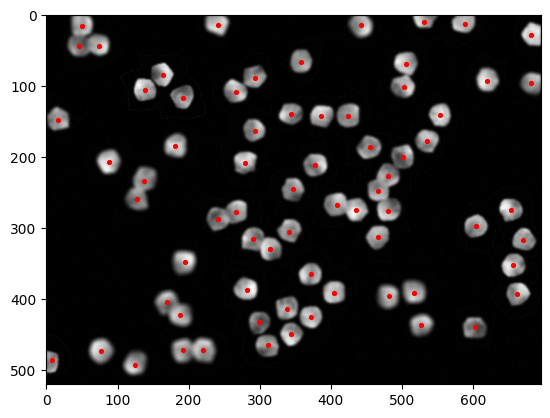

In [6]:
plt.imshow(img,cmap='gray')
plt.scatter(CenterList[:,0],CenterList[:,1], marker='.', s=30, c='red')
plt.show() #plot the points to see the data represent the original figure

In [7]:
%%time
BDsizethreshold=30#############################################Boundaries whose lengths are larger than this number are detected.
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
boundaryindex=np.array([l for l in range (0,len(contours)) if contours[l].shape[0]>BDsizethreshold])
boundarynumber=len(boundaryindex)
death_threshold=8#############################################Death points which are larger than this number are detected.
death_upper_threshold=200
lifethres=1#######threshold value for the persistence
birth_threshold=1######birth threshold (We don't need a short segment on a single circle.)
img_binary_copy=copy.deepcopy(img_binary)
for u in range (0,boundarynumber):   
    pointcloud=np.array([contours[boundaryindex[u]][t][0].tolist() for t in range (0,len(contours[boundaryindex[u]]))])
    hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True, save_phtrees=True)#Calculating persistent homology.
    pdlist = hc.PDList("pointcloud.pdgm")
    pd = pdlist.dth_diagram(1)
    pairs=pd.pairs()
    phtrees = pdlist.dth_diagram(1).load_phtrees()
    for w in range (0,len(pairs)):
        if pairs[w].birth_time()>birth_threshold and pairs[w].death_time()>death_threshold and pairs[w].death_time()<death_upper_threshold and pairs[w].death_time()-pairs[w].birth_time()>lifethres:
            node = phtrees.pair_node_nearest_to(pairs[w].birth_time(),pairs[w].death_time())
            birth_simplex_points=node.birth_simplex()
            cv2.line(img_binary_copy,
                     pt1=(int(birth_simplex_points[0][0]),int(birth_simplex_points[0][1])),
                     pt2=(int(birth_simplex_points[1][0]),int(birth_simplex_points[1][1])),
                     thickness=2,
                     color=(0,0,0),
                     lineType=cv2.LINE_8,
                     shift=0)

CPU times: total: 797 ms
Wall time: 1.23 s


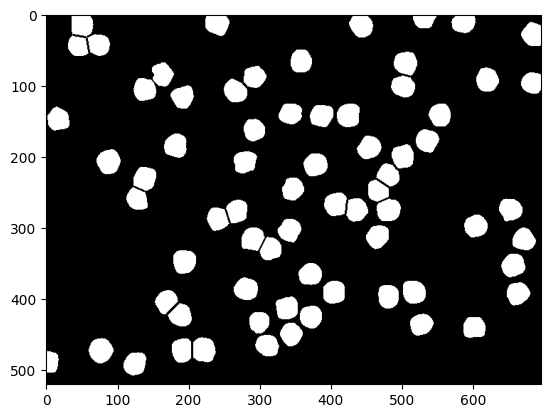

In [8]:
plt.imshow(img_binary_copy,cmap='gray')
plt.show()

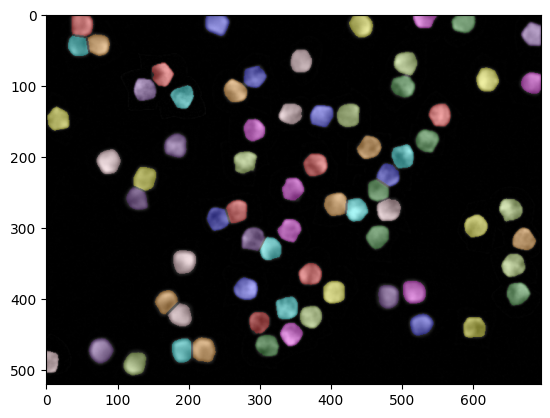

In [9]:
ret, bin_img = cv2.threshold(img_binary_copy, 20, 255, cv2.THRESH_BINARY)
n_labels, labels = cv2.connectedComponents(bin_img)
image_label_overlay = label2rgb(labels, image=img, bg_label=0)
plt.imshow(image_label_overlay)
plt.show()